In [1]:
%cd ../..

import pandas as pd
from scripts.utils import *


hg38 = import_pyensembl(38)
hg19 = import_pyensembl(37)

/run/media/nazif/2F946E411BA61D49/thesis


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /run/media/nazif/2F946E411BA61D49/data/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /run/media/nazif/2F946E411BA61D49/data/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /run/media/nazif/2F946E411BA61D49/data/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /run/media/nazif/2F946E411BA61D49/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /run/media/nazif/2F946E411BA61D49/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /run/media/nazif/2F946E411BA61D49/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.pep

In [2]:
def read_gff_file(file_path):
    # Read the gff file into a DataFrame
    df = pd.read_csv(file_path, sep="\t", header=None)

    # Create a rename dictionary
    rename_dict = {
        0: 'chr',
        1: 'drop',
        2: 'biotype',
        3: 'start',
        4: 'end',
        5: 'drop2',
        6: 'strand',
        7: 'drop3',
        8: 'other_data'
    }

    # Rename the columns based on the rename dictionary
    df = df.rename(columns=rename_dict)

    df[['id', 'alias', 'name', 'derives_from']] = (df["other_data"].str.split(';', expand=True)
                                                   .apply(lambda x:x.str.split('=', expand=True)[1]))

    df['chr'] = df['chr'].str.replace('chr', '')

    df.drop(columns=["drop", "drop2", "drop3", "other_data"], inplace=True)

    return df


In [3]:
raw = read_gff_file("crossmap/hsa.gff3")
converted_mirnas = read_gff_file("crossmap/hsa_mirnas_grch37.gff3")
non_converted_mirnas = read_gff_file("crossmap/hsa_mirnas_grch37.gff3.T99YAPR8.unmap")

mirbase = pd.read_csv("data/processed/mirbase/mirbase22_no_conservation.csv")


In [4]:
# assigning length col
converted_mirnas = converted_mirnas.assign(length=converted_mirnas["end"] - converted_mirnas["start"])

print(f"mean of primary transcript lengths\n{converted_mirnas[converted_mirnas.biotype == 'miRNA_primary_transcript'].length.mean()}")

print(f"mean of mirna lengths\n{converted_mirnas[converted_mirnas.biotype == 'miRNA'].length.mean()}")



mean of primary transcript lengths
80.916361735494
mean of mirna lengths
20.625824366539398


In [5]:
mirnas_without_hg19_coord = non_converted_mirnas.query("biotype == 'miRNA'").name

for i in mirnas_without_hg19_coord:
    if i in mirbase["name"].values:
        print(f"{i} is in miRBase")

hsa-miR-6859-3p is in miRBase
hsa-miR-4477a is in miRBase
hsa-miR-4477b is in miRBase


# exploring raw gff file from mirbase

In [6]:

len(raw.query("biotype == 'miRNA'"))

2883

In [7]:
len(raw.query("biotype == 'miRNA'").name.unique())

2652

In [8]:
for i in mirbase["name"].values:
    if i not in raw.query("biotype == 'miRNA'").name.unique():
        print(f"{i} is not in raw gff")

hsa-miR-1973 is not in raw gff
hsa-miR-3713 is not in raw gff
hsa-miR-378g is not in raw gff
hsa-miR-4456 is not in raw gff


2883 miRNA records in gff. 2652 unique miRNAs. miRBase 22 has 2656 miRNAs.

hsa-miR-1973, hsa-miR-3713, hsa-miR-378g, hsa-miR-4456 are not in gff but in miRBase 22

In [9]:
mirnas_not_in_raw_file = [
    i
    for i in raw.query("biotype == 'miRNA'").name.unique()
    if i not in mirbase["name"].values
]

len(mirnas_not_in_raw_file)

0

# visualizing mirnas without hg19 coords

In [10]:
mirnas_without_hg19_coord

1    hsa-miR-6859-3p
5      hsa-miR-4477a
7      hsa-miR-4477b
Name: name, dtype: object

hsa-miR-6859-3p	position is the same

In [11]:
raw.query("name in @mirnas_without_hg19_coord")

,chr,biotype,start,end,strand,id,alias,name,derives_from
2,1,miRNA,17369,17391,-,MIMAT0027619,MIMAT0027619,hsa-miR-6859-3p,MI0022705
7,1,miRNA,187891,187913,-,MIMAT0027619_1,MIMAT0027619,hsa-miR-6859-3p,MI0026420
1536,15,miRNA,101973569,101973591,+,MIMAT0027619_2,MIMAT0027619,hsa-miR-6859-3p,MI0026421
1539,16,miRNA,17052,17074,-,MIMAT0027619_3,MIMAT0027619,hsa-miR-6859-3p,MI0031521
4316,9,miRNA,41233802,41233823,+,MIMAT0019004,MIMAT0019004,hsa-miR-4477a,MI0016829
4318,9,miRNA,41233765,41233786,-,MIMAT0019005,MIMAT0019005,hsa-miR-4477b,MI0016830
4320,9,miRNA,63819623,63819644,+,MIMAT0019005_1,MIMAT0019005,hsa-miR-4477b,MI0016830
4322,9,miRNA,63819586,63819607,-,MIMAT0019004_1,MIMAT0019004,hsa-miR-4477a,MI0016829


# mir 4477b

In [47]:
# index 4320 hsa-miR-4477b
print(hg19.transcript_names_at_locus(9,63819623, 63819644))
print(hg38.transcript_names_at_locus(9,63819623, 63819644))

[]
['MIR4477B-201']


In [52]:
# print(hg19.transcripts_by_name("MIR4477B-201")[0])
print(hg38.transcripts_by_name("MIR4477B-201")[0])

Transcript(transcript_id='ENST00000581659', transcript_name='MIR4477B-201', gene_id='ENSG00000266017', biotype='miRNA', contig='9', start=63819574, end=63819654, strand='+', genome='GRCh38')


In [12]:
# index 4316 hsa-miR-4477a
print(hg19.transcript_names_at_locus(9,41233802, 41233823))
print(hg38.transcript_names_at_locus(9,41233802, 41233823))



[]
['MIR4477A-201']


In [13]:
# index 4318 hsa-miR-4477b
print(hg19.transcript_names_at_locus(9,41233765, 41233786))
print(hg38.transcript_names_at_locus(9,41233765, 41233786))

[]
['MIR4477A-201']


In [39]:
print(hg38.transcript_names_at_locus(9,41233765, 41233823))


['MIR4477A-201']


In [46]:
print(hg19.transcripts_by_name("MIR4477A-201")[0])
print(hg38.transcripts_by_name("MIR4477A-201")[0])

Transcript(transcript_id='ENST00000581659', transcript_name='MIR4477A-201', gene_id='ENSG00000266017', biotype='miRNA', contig='9', start=68415308, end=68415388, strand='+', genome='GRCh37')
Transcript(transcript_id='ENST00000612572', transcript_name='MIR4477A-201', gene_id='ENSG00000276029', biotype='miRNA', contig='9', start=41233755, end=41233835, strand='+', genome='GRCh38')


In [14]:
print(hg19.transcripts_by_name("MIR4477A-201")[0].sequence)
print(len(hg19.transcripts_by_name("MIR4477A-201")[0].sequence))

ACCTCCTCCCGTGAATCACAAATGTCCTTAATAGCAATCCTTAAATGCCATTAAGGACATTTGTGATTGATGGGAGGAGGA
81


querying MI0016829 accession (precursor of mir4477a and b) from mirbase

link = https://mircarta.cs.uni-saarland.de/precursor_view/MI0016829/

In [15]:
MI0016829_sequence = "UCCUCCUCCCAUCAAUCACAAAUGUCCUUAAUGGCAUUUAAGGAUUGCUAUUAAGGACAUUUGUGAUUCACGGGAGGAGGU"
print(len(MI0016829_sequence))

81


In [16]:
MI0016829_sequence_from_hg19 = hg19.transcripts_by_name("MIR4477A-201")[0].sequence

reverse_complement_dna_to_rna(MI0016829_sequence_from_hg19) == MI0016829_sequence

True

sequences are the same.

In [18]:
mir4477a_seq = mirbase[mirbase.name == "hsa-miR-4477a"].sequence.values.tolist()[0]
mir4477b_seq = mirbase[mirbase.name == "hsa-miR-4477b"].sequence.values.tolist()[0]


In [36]:
print(invoke_rnaduplex(MI0016829_sequence_from_hg19, reverse_complement_rna_to_dna(mir4477a_seq)))

print(MI0016829_sequence_from_hg19[12:34])
print(reverse_complement_rna_to_dna(mir4477a_seq)[::-1])

(11, 34, '.((((((((((((((((((((((.', 0, 21, '))))))))))))))))))))))', -32.1)
GAATCACAAATGTCCTTAATAG
CTTAGTGTTTACAGGAATTATC


In [37]:
print(invoke_rnaduplex(MI0016829_sequence_from_hg19, reverse_complement_rna_to_dna(mir4477b_seq)))

print(MI0016829_sequence_from_hg19[9:32])
print(reverse_complement_rna_to_dna(mir4477b_seq)[::-1])


(9, 32, '.((.(((((((((((((((((((.', 0, 21, '))))))))))))))))))).))', -28.0)
CGTGAATCACAAATGTCCTTAAT
TAGTTAGTGTTTACAGGAATTA


In [30]:
hg19.transcripts_by_name("MIR4477A-201")[0].start

68415308

In [31]:
hg19.transcripts_by_name("MIR4477A-201")[0]

Transcript(transcript_id='ENST00000581659', transcript_name='MIR4477A-201', gene_id='ENSG00000266017', biotype='miRNA', contig='9', start=68415308, end=68415388, strand='+', genome='GRCh37')

In [35]:
hg19.transcripts_at_locus(9,68415308, 68415388)[0].sequence[12:34]

'GAATCACAAATGTCCTTAATAG'

In [38]:
hg19.transcripts_at_locus(9,68415308, 68415388)[0].sequence[10:32]


'GTGAATCACAAATGTCCTTAAT'

# 447b web search

https://www.ncbi.nlm.nih.gov/gene/100616194

38 location: NC_000009.12 (chr9:63819574-63819654) 

37 location = NC_000009.11 (chr9:68415308-68415388) 

In [54]:
hg19.transcripts_at_locus(9, 68415308, 68415388)

[Transcript(transcript_id='ENST00000581659', transcript_name='MIR4477A-201', gene_id='ENSG00000266017', biotype='miRNA', contig='9', start=68415308, end=68415388, strand='+', genome='GRCh37')]

# 447A web search

https://grch37.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000266017;r=9:68415308-68415388;t=ENST00000581659


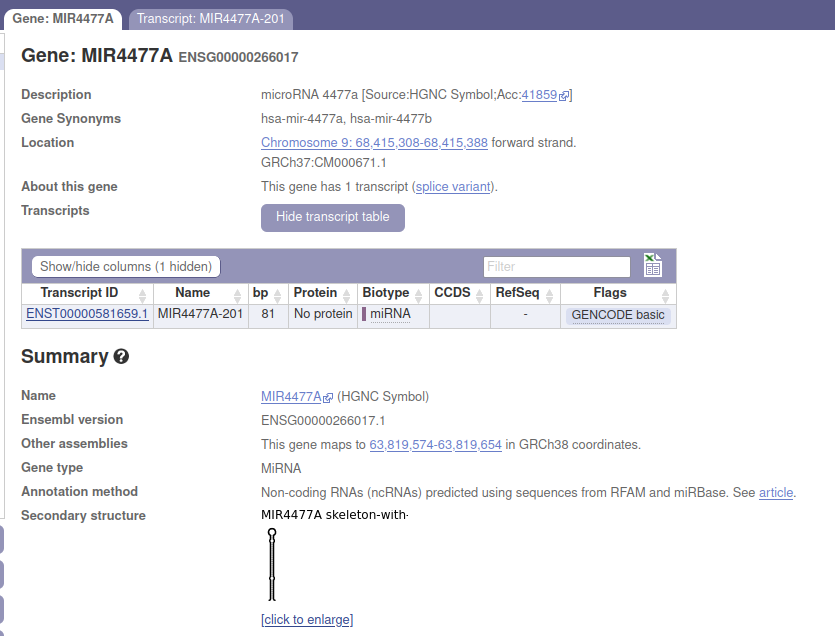

In [57]:
print(mirbase[mirbase.name == "hsa-miR-4477a"])
print(mirbase[mirbase.name == "hsa-miR-4477b"])

               name     accession                sequence
1493  hsa-miR-4477a  MIMAT0019004  GAAUCACAAAUGUCCUUAAUAG
               name     accession                sequence
1494  hsa-miR-4477b  MIMAT0019005  AUCAAUCACAAAUGUCCUUAAU
